In [3]:
import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('presentation.mplstyle')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
import scipy
import statsmodels.api as sm
import hashlib

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
all_analysis_folders = get_analysis_folders()

plate_select = [792,1014,1042,127,130,1023,1045,1053,1048,52,84,938,1076,94,152,102,76,30,32,33,91,799,800] #C2
plates = ['1014_20220525', '1023_20220502', '102_20201226', '1042_20220523',
       '1045_20220504', '1048_20220506', '1053_20220413', '1076_20220511',
       '127_20220705', '130_20220707', '152_20201224', '30_20220509',
       '32_20220428', '33_20220502', '52_20220707', '76_20210108',
       '792_20210915', '799_20211001', '800_20210928', '84_20220621', '91_20220708', '938_20220325', '94_20201123']
plates = [
"10_20210107",
"26_20210104",
"38_20201202",
"42_20201204",
"48_20201207",
# "55_20210113",
"59_20201126",
"60_20201204",
"64_20201130",
"66_20201214",
"67_20201202",
"69_20201119",
"92_20201209",
"90_20201209",
"99_20201210",
"112_20201209",
"127_20201209",
"138_20201207",
"162_20201207"]
analysis_folders = all_analysis_folders.loc[all_analysis_folders['unique_id'].isin(plates)]


In [5]:
folders,time_plate_info = get_time_plate_info_from_analysis(analysis_folders,False)
folders,global_hypha_info = get_global_hypha_info_from_analysis(analysis_folders,False)
folders, time_hypha_info = get_time_hypha_info_from_analysis(analysis_folders,False)

In [6]:
plate

55

C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\matplotlib\axes\_axes.py:1174: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
C:\Users\coren\anaconda3\envs\amftrack\lib\site-packages\matplotlib\axes\_axes.py:1175: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


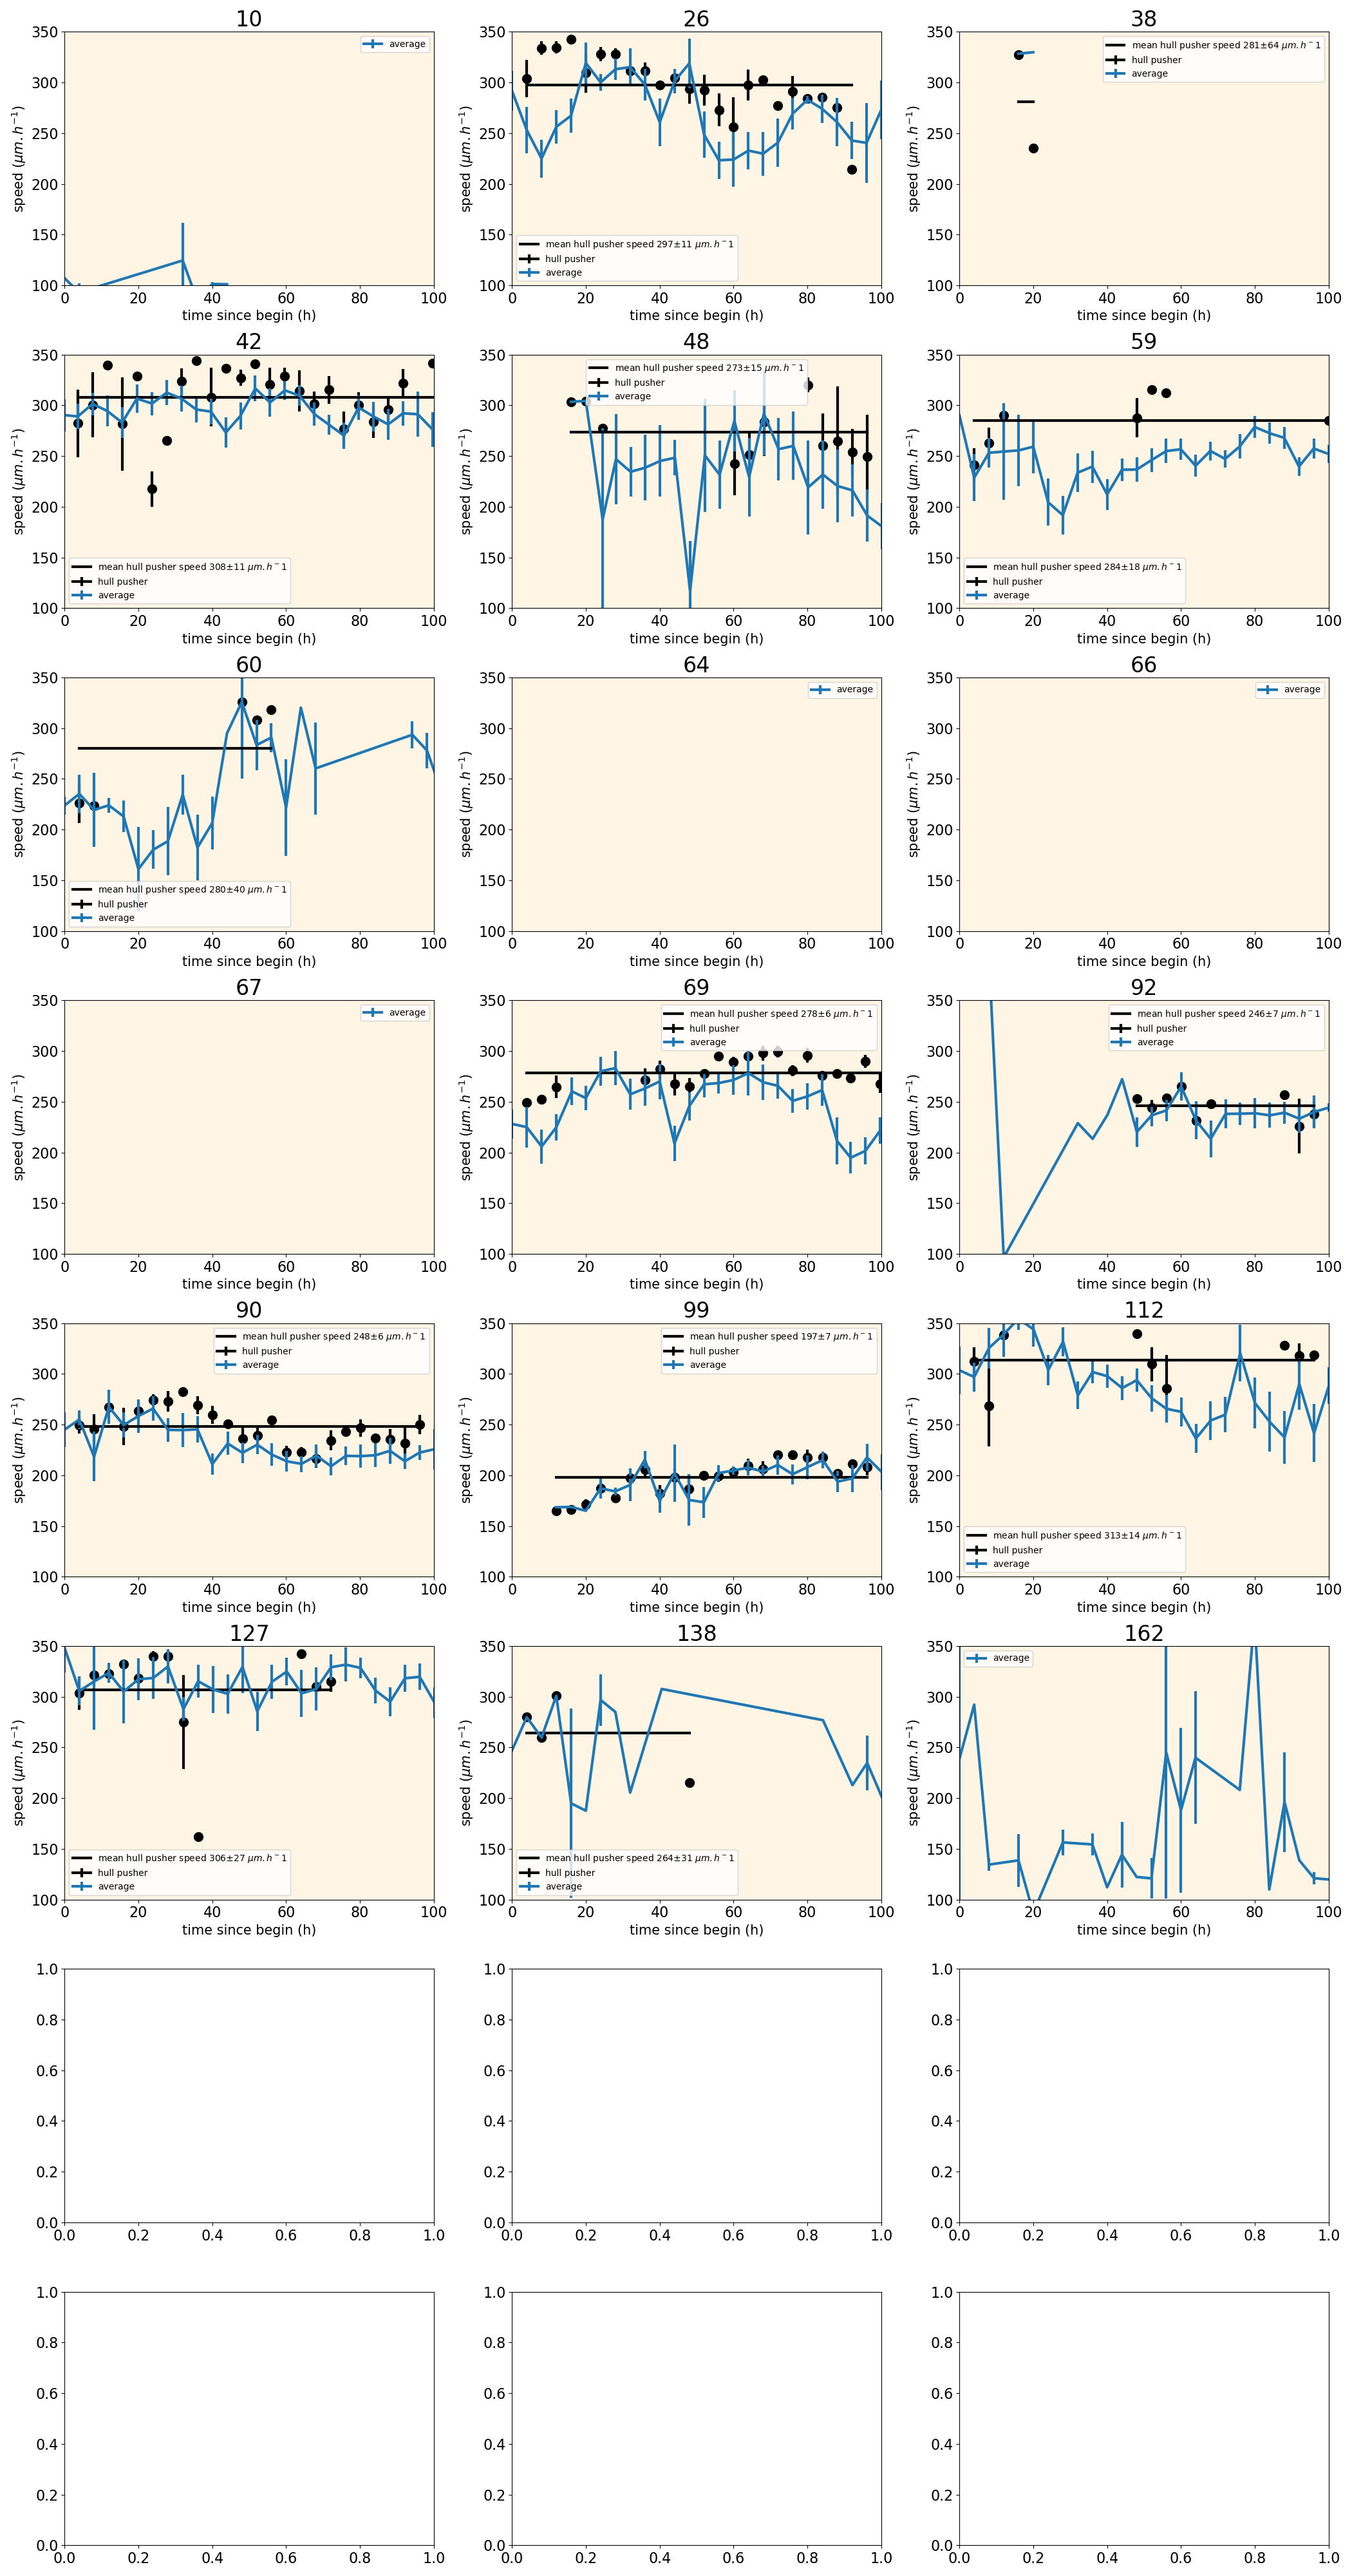

In [6]:
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
ax_list = list(axs)
min_time = {plate_id : 0 for plate_id in plates}
max_time = {plate_id : 100 for plate_id in plates}
min_time['799_20211001'] = 100
max_time['799_20211001'] = 200
hull_speeds_dic = {}
hull_time_dic = {}
datas = {}
dys = {}
for j in range(len(plates)):
    plate_id=plates[j]
    plate  = int(plate_id.split('_')[0])
    ax = ax_list[j]
    hull_speeds = []
    hull_time = []
    time_hypha_plate = time_hypha_info.loc[time_hypha_info['unique_id']==int(plate_id)]
    data,dy,select_movements = get_average_time_data(int(plate_id),time_hypha_plate,2)
    hyphae_hull = get_hyphae_hull(plate_id,analysis_folders)
    if len(hyphae_hull)>0:
        label = 'hull pusher'
        for t in range(1,len(time_hypha_plate['timestep'].unique())-1):
            select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
            select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
            select = select.loc[select['speed'].between(150,350)]
            if len(select)>0:
                time = select['time_since_begin_h'].iloc[0]
                if time/pd.Timedelta(hours = 1)<=max_time[plate_id] and time/pd.Timedelta(hours = 1)>=min_time[plate_id]:
                    ax.scatter(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),color='black')
                    ax.errorbar(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1),np.mean(select["speed"]),np.std(select["speed"])/np.sqrt(len(select)),color='black',label=label)
                    label = None
                    hull_speeds.append(np.mean(select["speed"]))
                    hull_time.append(select['time_since_begin_h'].iloc[0]/pd.Timedelta(hours = 1))

                select = time_hypha_plate.loc[time_hypha_plate['timestep']==t]
                # select = select.loc[select['end'].isin(hyphae_hull[t-1]) |select['end'].isin(hyphae_hull[t]) |select['end'].isin(hyphae_hull[t+1])]
        # ax.plot(data.index/pd.Timedelta(hours = 1),data)
        ax.errorbar(data.index/pd.Timedelta(hours = 1),data, yerr=dy,label='average')
        ax.set_xlim(0,150)
        ax.set_ylim(100,350)

        ax.legend()
        # ax.set_title(f'{plate}')
        ax.set_xlabel('time since begin (h)')
        ax.set_ylabel('speed ($\mu m.h^{-1}$)')
            # break
        ax.set_xlim(0,100)
        plt.tight_layout()
        if len(hull_speeds)>0:
            ax.plot(hull_time,[np.mean(hull_speeds)]*len(hull_time),
                    color="black",
                    label= f'mean hull pusher speed {int(np.nanmean(hull_speeds))}$\pm${int(2*np.nanstd(hull_speeds)/np.sqrt(len(hull_speeds)))} $\mu m.h^{-1}$')
            ax.legend()
    datas[plate] = data
    dys[plate] = dy
    hull_speeds_dic[plate] = hull_speeds
    hull_time_dic[plate] = hull_time
    ax.patch.set_facecolor(get_color(plate,folders))
    ax.patch.set_alpha(0.1)
    ax.set_title(plate)
    plt.tight_layout()

    # break
# plt.savefig(f'Figure/FigureS2C.svg')    

In [9]:
Css = {}
lambss = {}
dss = {}
meancurves = {}
meancurves2 = {}
t0ss = {}
rsquared = {}

timestep = {32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 65,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:150,152:35,792:60,1048:60,1045:50,941:50}
timestep2 = {102:25,83:70,76:20,81:70,32:100,28:60,30:80,1014: 80, 1023:60, 1037:70, 1042:100,52 : 75,56:50,938:30,1076:60,84:80,89:80,91:70,127:60,129:50,94:100,152:35,792:50,1048:60,1045:50}
timestep = {**timestep, **timestep2}
timestep2 = {1014 : 80,1024:25,1027:18,1028:60,1030 : 60,1032 : 50,1042 : 120,1048:70,127:120,129:60,130:50,991:40}
timestep = {**timestep, **timestep2}
timestep2 = {1023 : 60,1031:30,1035:30,1037 : 80,1039 : 90,1045:70,1047:50,1053:40}
timestep = {**timestep, **timestep2}    

timestep2 = {1071 : 25,1076:70,839:60,938 : 35}
timestep = {**timestep, **timestep2}
timestep2 = {30 : 62,32 : 160,33:80}
timestep = {**timestep, **timestep2}
timestep2 = {799 : 100,800 : 25,91:100,99:40}
timestep = {**timestep, **timestep2}

In [10]:
def make_stat(x0,ax):
    def statistic(x,y):
        X = sm.add_constant(x, prepend=False)
        model = sm.OLS(y,X)
        res = model.fit()
        a,b = res.params[0],res.params[1]
        ax.plot(x0,np.array(x0)*a+b,color = 'grey', alpha = 0.01)
        return(a)
    return(statistic)

In [13]:
plate_select

[792,
 1014,
 1042,
 127,
 130,
 1023,
 1045,
 1053,
 1048,
 52,
 84,
 938,
 1076,
 94,
 152,
 102,
 76,
 30,
 32,
 33,
 91,
 799,
 800]

c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\density_wave.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
c:\users\coren\documents\phd\code\amftrack\amftrack\pipeline\final_analysis\

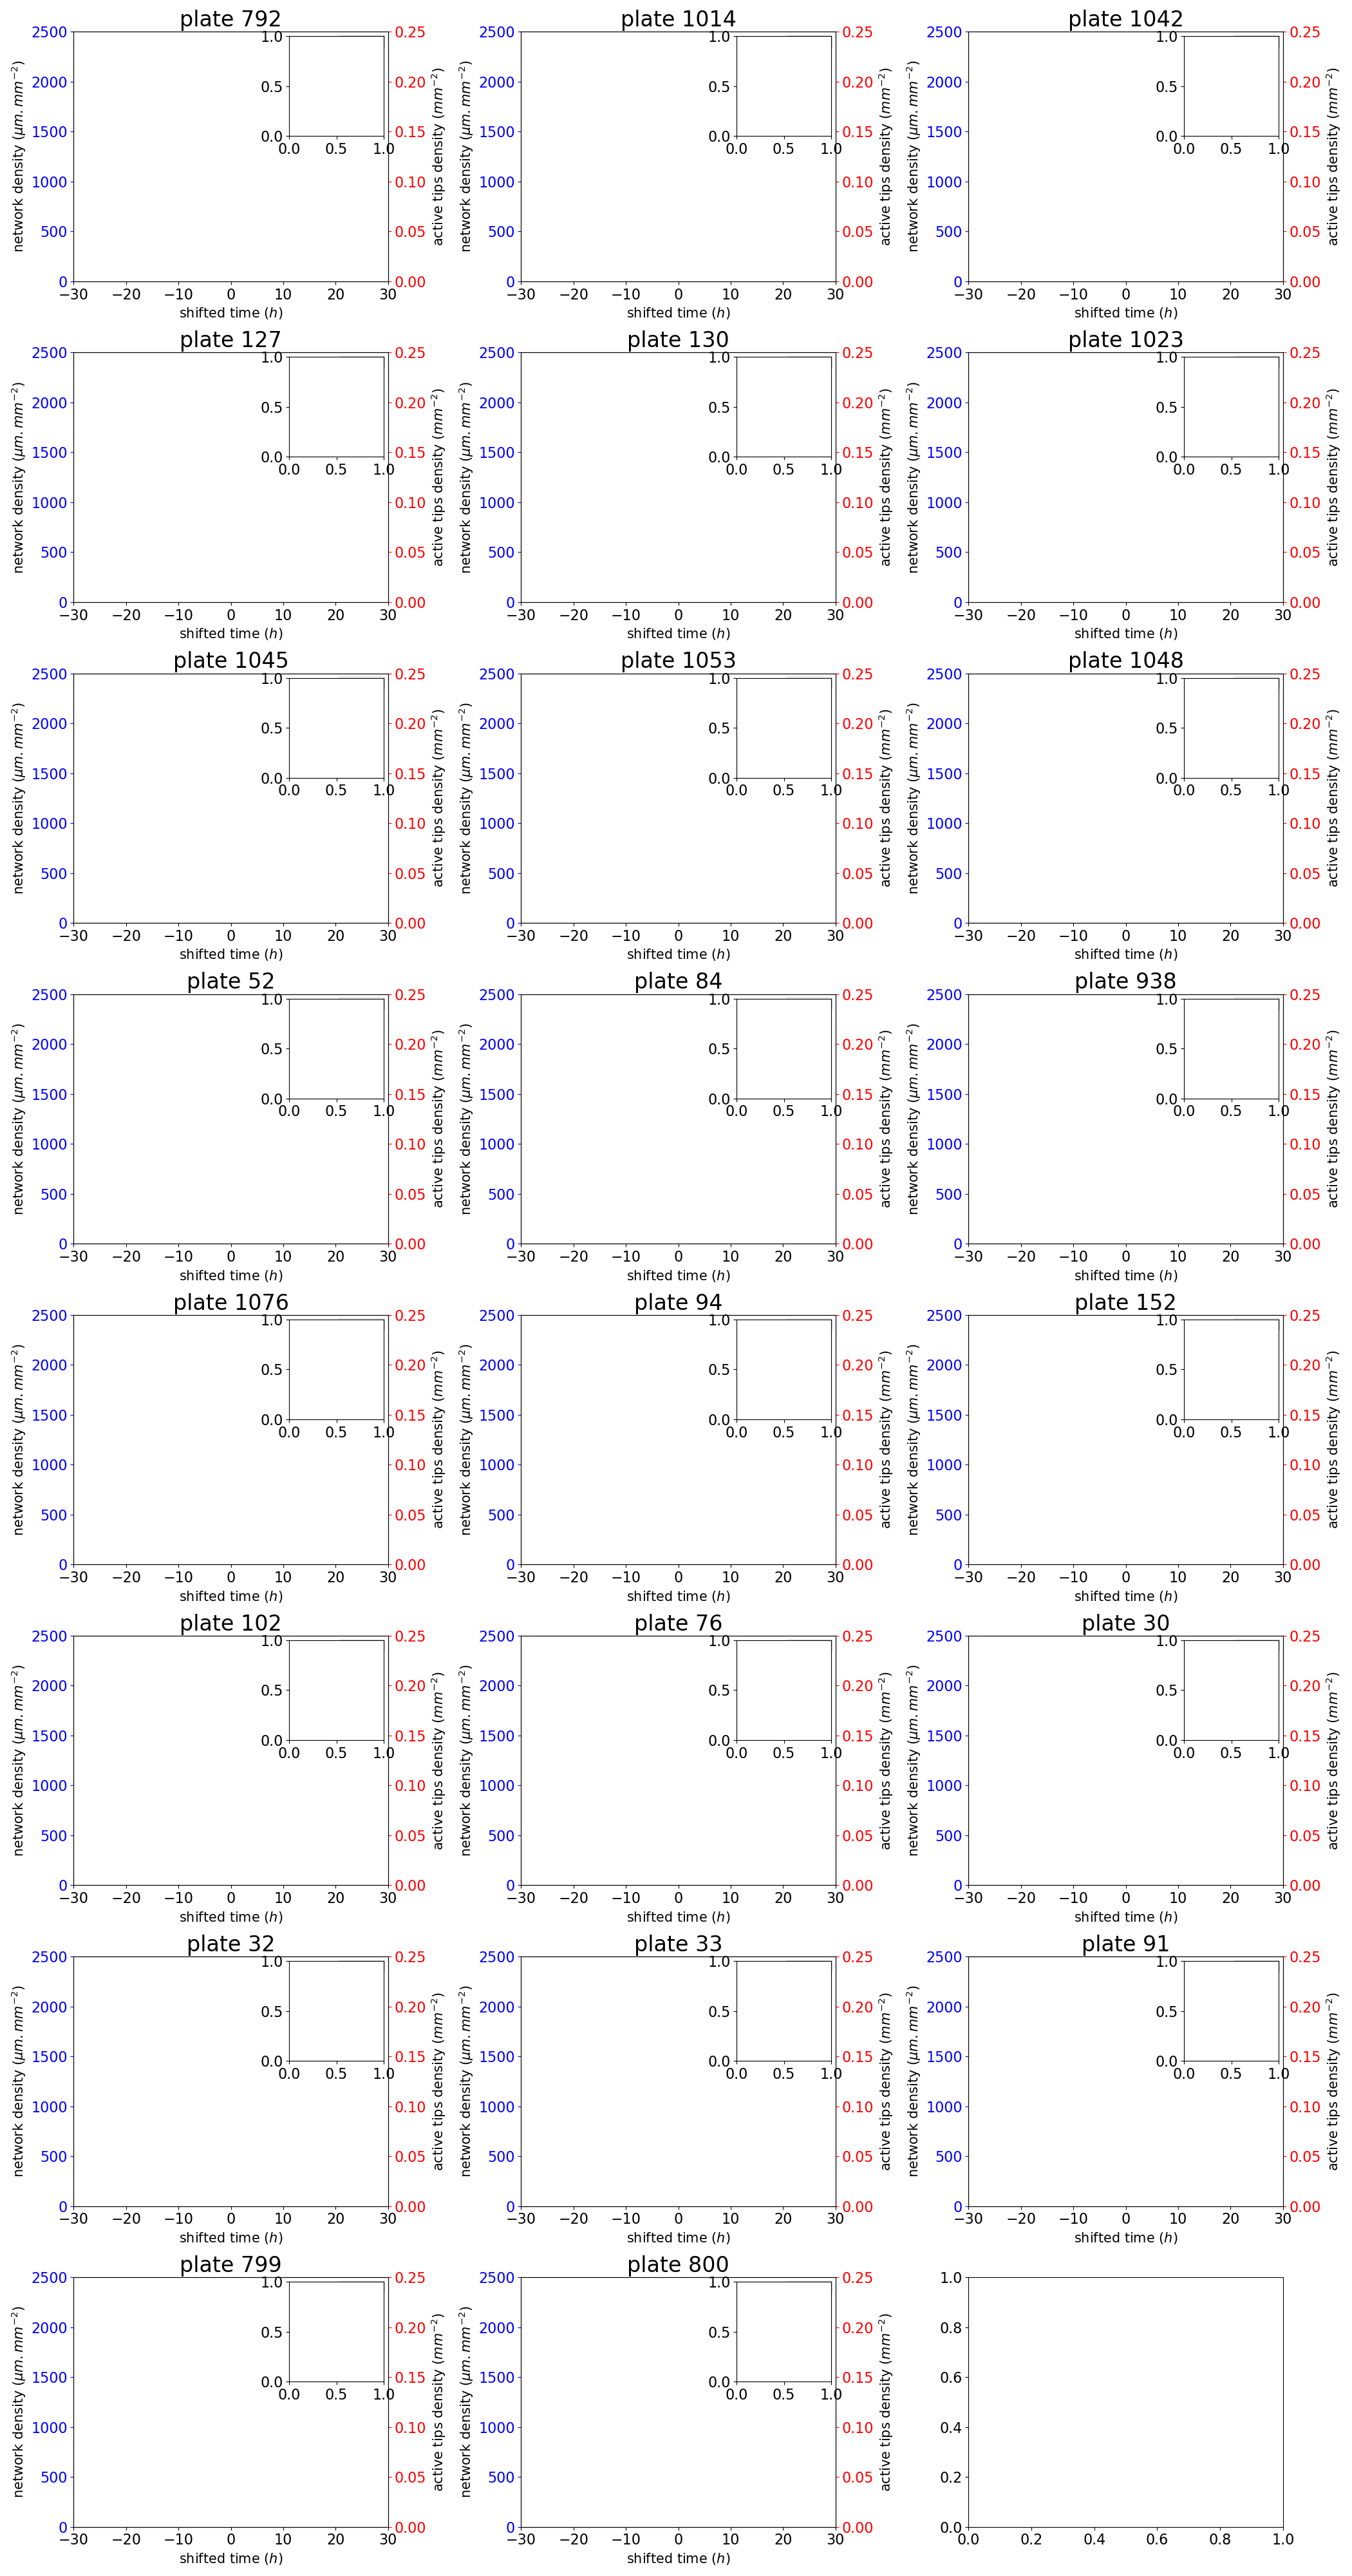

In [11]:

# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)

maxis = {plate :12 for plate in plate_select}
maxis[94] = 13
maxis[152] = 11
maxis2 = {plate :12 for plate in plate_select}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
    meancurves[plate]=meancurve
    meancurves2[plate]=meancurve2
    Css[plate] = Cs
    lambss[plate] = lambs
    dss[plate] = ds
    t0ss[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    if len(ds)>0:
        x0 = np.linspace(np.min(ds),np.max(ds),10)
        statistic = make_stat(x0,axins2)

        data = np.array((ds,Cs))
#         n_resamples=1000
#         std = scipy.stats.bootstrap(data,statistic,
#                                     vectorized = False,
#                                     method="basic",
#                                     n_resamples = n_resamples,
#                                     paired= True).standard_error
#         X = sm.add_constant(ds, prepend=False)
#         model = sm.OLS(Cs,X)
#         res = model.fit()
#         a,b = res.params[0],res.params[1]
#         axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
#         axins2.scatter(ds,Cs,s = 2)
#         axins2.set_ylim(0,4000)
        ax.set_ylim(0,4000)

#         axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
#         axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
#         axins2.tick_params(labelsize = 5)
#         axins2.legend(fontsize = 6)
        ax.patch.set_facecolor(get_color(plate,folders))
        ax.patch.set_alpha(0.1)
    # break
plt.savefig(f'Figure/FigureS2B.svg')    

IndexError: single positional indexer is out-of-bounds

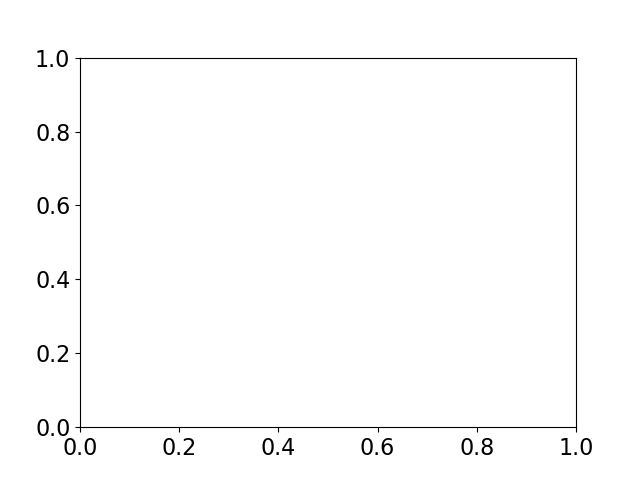

In [12]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    ds = dss[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    tot_ds+=ds
    tot_Cs+=Cs
    ax.plot(ds,Cs,color=colors[treatment])
patches = []
for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
    print(treatment)
    patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
ax.legend(handles=patches)
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation density ($\mu m.mm^{-1}$)')
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed),color=colors[treatment],alpha=0.2,marker ='x') 
    ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('hull pusher speed ($\mu m .h^{-1}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
plate_select

In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
# plate_select.remove(30)
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
# plate_select.remove(30)
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(hull_speed),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('expansion speed ($\mu m .h^{-1}$)'  ) 
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    # print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_speed[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
for strain in strains:
    print(strain)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain) 
    ax.errorbar(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),np.nanstd(values_speed[strain])/np.sqrt(len(values_speed[strain])))    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('hull pusher speed ($\mu m .h^{-1}$)'  ) 
plt.legend()
plt.tight_layout()
plt.savefig(f'Figure/Figure2B.svg')    

In [12]:
plate_2022 = [plate for plate in plate_2022 if plate!=30]
plate_2022

NameError: name 'plate_2022' is not defined

In [ ]:
column = "ring_biovolume_density_incr-100_index-0"
plate_select = time_plate_info.loc[~time_plate_info[column].isnull()]['Plate'].unique().tolist()
folders['CrossDate'] = folders['CrossDate'].astype(str).str.replace("'","").astype(int)
plate_2022 = folders.loc[folders['CrossDate']>20220101]['Plate'].unique()
plate_2022 = [plate for plate in plate_2022 if plate!=30]

plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_select]
plates = [plate for plate in plates if int(plate.split('_')[0]) in plate_2022]
plate_select = [int(plate.split('_')[0])  for plate in plates]

In [ ]:

# plt.close('all')
ncols = 3
fig,axs = gridplot(len(plate_select),ncols = ncols,subh = 5,subw = 7)
meancurves3 = {}
meancurves4 = {}
Css2 = {}
lambss2 = {}
dss2 = {}
t0ss2 = {}
maxis = {plate :12 for plate in plate_select}
maxis[94] = 13
maxis[152] = 11
maxis2 = {plate :12 for plate in plate_select}
maxis2[52] = 6
maxis2[938] = 7
# maxis[938] = 8

bbox = dict(facecolor='white', alpha = 0.7,edgecolor="None")

ax_list = list(axs)
for j in range(len(plate_select)):
    plate=plate_select[j]
    ax = ax_list[j]
    Cs, lambs,ds,indexes, t0s,meancurve,meancurve2 = plot_single_plate_biovolume(plate,time_plate_info,timestep[plate],ax,maxi =maxis[plate])
    meancurves3[plate]=meancurve
    meancurves4[plate]=meancurve2
    Css2[plate] = Cs
    lambss2[plate] = lambs
    dss2[plate] = ds
    t0ss2[plate] = t0s
    axins2 = inset_axes(ax, width="30%", height="40%", loc=1)
    if len(ds)>0:
        x0 = np.linspace(np.min(ds),np.max(ds),10)
        statistic = make_stat(x0,axins2)

        data = np.array((ds,Cs))
#         n_resamples=1000
#         std = scipy.stats.bootstrap(data,statistic,
#                                     vectorized = False,
#                                     method="basic",
#                                     n_resamples = n_resamples,
#                                     paired= True).standard_error
#         X = sm.add_constant(ds, prepend=False)
#         model = sm.OLS(Cs,X)
#         res = model.fit()
#         a,b = res.params[0],res.params[1]
#         axins2.plot(ds,np.array(ds)*a+b,label = f"{round(a,1)}$\pm$ {round(std,1)}$\mu m.mm^{-3}$",color="black")
#         axins2.scatter(ds,Cs,s = 2)
#         axins2.set_ylim(0,4000)
        ax.set_ylim(0,4000)

#         axins2.set_xlabel('distance from origin (mm)',size = 5,bbox=bbox)
#         axins2.set_ylabel('saturation density($\mu m.mm^{-2}$)',size = 5,bbox=bbox)
#         axins2.tick_params(labelsize = 5)
#         axins2.legend(fontsize = 6)
        ax.patch.set_facecolor(get_color(plate,folders))
        ax.patch.set_alpha(0.1)
    # break
# plt.savefig(f'Figure/FigureS2B.svg')    

In [ ]:
fig, ax = plt.subplots()
tot_ds = []
tot_Cs=[]
# plates = [52,152,94,102,83,84,792,76]
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    ds = dss2[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    tot_ds+=ds
    tot_Cs+=Cs
    ax.plot(ds,Cs,color=colors[treatment])
patches = []
for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
    print(treatment)
    patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
ax.legend(handles=patches)
ax.set_xlabel('distance from origin (mm)')
ax.set_ylabel('saturation biovolume density ($\mu m^{3}.mm^{-1}$)')
plt.tight_layout()


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed),color=colors[treatment],alpha=0.2,marker ='x') 
    ax.errorbar(np.mean(Cs),np.mean(hull_speed),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('hull pusher speed ($\mu m .h^{-1}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(values_speed[strain]),label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.mean(hull_speed)**2*np.mean(Cs)*1e-9,color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('biovolume saturation density ($\mu m^{3} .mm^{-2}$)')
ax.set_ylabel('biovolume growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_speed = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs = Css2[plate]
    hull_speed = hull_speeds_dic[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_speed[strain].append(np.mean(hull_speed))
    values_density[strain].append(np.mean(Cs))
    
values_density["'A5'"] += values_density["'A5sp3'"]
values_speed["'A5'"] += values_speed["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    print(strain,np.nanmean(values_density[strain])*np.nanmean(values_speed[strain])**2*1e-9)
    ax.scatter(np.nanmean(values_density[strain]),np.nanmean(np.array(values_density[strain])*np.array(values_speed[strain])**2)*1e-9,label = strain,s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.sqrt(np.mean(Cs2)/np.mean(Cs)/np.pi),color=colors[treatment],alpha=0.2,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('effective mean radius ($\mu m$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_density_biovolume = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_density[strain].append(np.mean(Cs))
    values_density_biovolume[strain].append(np.mean(Cs2))
values_density["'A5'"] += values_density["'A5sp3'"]
values_density_biovolume["'A5'"] += values_density_biovolume["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    ax.scatter(np.nanmean(values_density[strain]),np.sqrt(np.nanmean(np.array(values_density_biovolume[strain])/np.array(values_density[strain]))/np.pi),s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    


In [ ]:
fig, ax = plt.subplots()
# plates.remove(102)
# plates.remove(76)

for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    medium = folders.loc[folders['Plate']==plate].iloc[0]['medium']
    treatment = strain+medium
    ax.scatter(np.mean(Cs),np.sqrt(np.mean(Cs2)/np.mean(Cs)/np.pi),label=plate,marker ='x') 
    # ax.errorbar(np.mean(Cs),np.mean(hull_speed)*np.mean(Cs),np.std(hull_speed)/np.sqrt(len(hull_speed)),color=colors[treatment],alpha = 0.2)    
    
# for treatment in treatments:
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
ax.set_xlabel('saturation density ($\mu m .mm^{-2}$)')
ax.set_ylabel('growth coefficient ($mm .h^{-2}$)'  ) 
# patches = []
# for treatment in ["'A5''001P100N100C'","'A5''001P100N200C'","'C2''001P100N100C'","'C2''001P100N200C'","'Agg''001P100N100C'"]:
#     print(treatment)
#     patches.append(mpatches.Patch(color=colors[treatment], label=treatment))
# ax.legend(handles=patches)
values_density_biovolume = {strain : [] for strain in folders['strain'].unique()}
values_density = {strain : [] for strain in folders['strain'].unique()}
for j in range(len(plate_select)):
    plate=plate_select[j]
    Cs2 = Css2[plate]
    Cs = Css[plate]
    strain = folders.loc[folders['Plate']==plate].iloc[0]['strain']
    values_density[strain].append(np.mean(Cs))
    values_density_biovolume[strain].append(np.mean(Cs2))
values_density["'A5'"] += values_density["'A5sp3'"]
values_density_biovolume["'A5'"] += values_density_biovolume["'A5sp3'"]
strains = list(values_speed.keys())
strains.remove("'A5sp3'")
colors_strain = {"'A5'" : 'orange',"'C2'" : 'blue',"'Agg'":'black'}
# length_production
for strain in strains:
    ax.scatter(np.nanmean(values_density[strain]),np.sqrt(np.nanmean(np.array(values_density_biovolume[strain])/np.array(values_density[strain]))/np.pi),s=400,alpha= 0.5,color = colors_strain[strain]) 
plt.tight_layout()
# plt.savefig(f'Figure/Figure2A.svg')    
ax.legend()

In [ ]:
selection = time_hypha_info.loc[time_hypha_info['Plate'].isin(plate_select)]
selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([1045, 1014, 1023, 1053, 1076,   52, 1042,   84])]
# selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([1045])]

# selection = time_hypha_info.loc[time_hypha_info['Plate'].isin([52,84])]
selection = selection.loc[selection['speed'].between(50,350)]
selection = selection.loc[selection['av_width'].between(0.5,12)]
selection = selection.loc[selection['width_tip_edge'].between(0.5,12)]

selection = selection.loc[selection['time_since_begin_h']/pd.Timedelta(hours=1)<=150]

In [ ]:


selection.columns

In [ ]:
plates = selection['Plate'].unique()

In [ ]:
selection.columns
selection = selection.sort_values('av_width')
selection['speed_rolling']=selection['speed'].rolling(300).mean()

In [ ]:
selection['strain'] = selection['strain'].str.replace("'A5sp3'","'A5'")

In [ ]:
plates = [1045]

In [ ]:
strains = selection['strain'].unique()

In [ ]:
column = 'av_width'
for plate in plates:
    fig, ax = plt.subplots()
    
    subs_select = selection.loc[selection['Plate']==plate].copy()
    subs_select = subs_select.sort_values(column)
    subs_select['speed_rolling']=subs_select['speed'].rolling(300).quantile(0.8)
    ax.scatter(subs_select[column],subs_select['speed'],alpha = 0.01)
    ax.plot(subs_select[column],subs_select['speed_rolling'],color="red",label='80th percentile')
    ax.set_xlabel('hypha average width ($\mu m$)')
    ax.set_ylabel('hypha growth speed ($\mu m.h^{-1}$)')
    plt.tight_layout()
    ax.legend()

In [ ]:
values_density